# 1. Pra-pemrosesan Data

In [57]:
import pandas as pd
import joblib

# Membaca data
df = pd.read_csv('../data/tuberculosis_xray_dataset.csv')

In [58]:
# 1. Hapus kolom ID
df = df.drop(columns=['Patient_ID'])

In [59]:
# 2. Pisahkan fitur dan label
X = df.drop(columns=['Class'])
y = df['Class']

In [60]:
# 3. Label encoding untuk kolom target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Simpan encoder target
joblib.dump(label_encoder, f"../models/label_encoder_target.pkl")

['../models/label_encoder_target.pkl']

In [61]:
# 4. Label Encoding untuk kolom kategorikal
categorical_cols = X.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    joblib.dump(le, f"../models/encoder_{col}.pkl")  # Simpan encoder untuk digunakan ulang

In [62]:
# 5. Tangani class imbalance dengan SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [63]:
# 6. Cek distribusi baru
print("Distribusi label setelah SMOTE:")
print(pd.Series(y_resampled).value_counts().rename(index={0: 'Normal', 1: 'Tuberculosis'}))

Distribusi label setelah SMOTE:
Normal          14082
Tuberculosis    14082
Name: count, dtype: int64


# 2. Pelatihan model

In [66]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [67]:
# 1. Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [68]:
# 2. Buat dan latih model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

# 3. Evaluasi Model

In [24]:
# Evaluasi model
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      2924
           1       0.60      0.60      0.60      2709

    accuracy                           0.62      5633
   macro avg       0.62      0.62      0.62      5633
weighted avg       0.62      0.62      0.62      5633



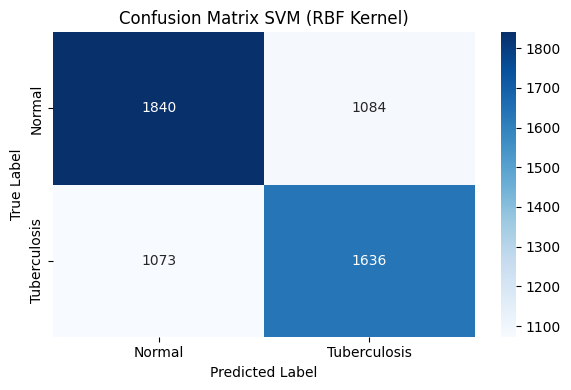

In [25]:
# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Normal', 'Tuberculosis']

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix SVM (RBF Kernel)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# 4. Menyimpan model dan encoder

In [26]:
# 4. Simpan model & encoder preprocessing
joblib.dump(svm_model, '../models/svm_model.pkl')
joblib.dump(encoders, '../models/encoders.pkl')

['../models/encoders.pkl']

In [30]:
# Ambil 1 data pasien dengan label 'Tuberculosis'
sample = df[df['Class'] == 'Tuberculosis'].iloc[0].drop('Class')
sample_dict = sample.to_dict()

# Tampilkan input
print("Input sampel:")
for k, v in sample_dict.items():
    print(f"{k}: {v}")


Input sampel:
Age: 89
Gender: Male
Chest_Pain: No
Cough_Severity: 7
Breathlessness: 0
Fatigue: 3
Weight_Loss: 2.86
Fever: Mild
Night_Sweats: Yes
Sputum_Production: Medium
Blood_in_Sputum: No
Smoking_History: Current
Previous_TB_History: No


In [ ]:
# 1. Encode fitur kategorikal
for col in categorical_cols:
    le = joblib.load(f"../models/encoder_{col}.pkl")
    val = sample_dict[col]
    if val not in le.classes_:
        val = le.classes_[0]  # fallback
    sample_dict[col] = le.transform([val])[0]

# 2. Scaling fitur numerik
numeric_cols = ['Age', 'Cough_Severity', 'Breathlessness', 'Fatigue', 'Weight_Loss']
scaler = joblib.load("../models/scaler.pkl")
sample_df = pd.DataFrame([sample_dict])
sample_df[numeric_cols] = scaler.transform(sample_df[numeric_cols])

# 3. Prediksi
model = joblib.load("../models/svm_model.pkl")
pred = model.predict(sample_df)[0]

# 4. Konversi ke label asli
le_target = joblib.load("../models/label_encoder_target.pkl")
print("Prediksi:", le_target.inverse_transform([pred])[0])


d:\Final Project\Klasifikasi TBC\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


TypeError: float() argument must be a string or a real number, not 'dict'